In [1]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import OSM, GoogleTiles, StadiaMapsTiles, MapQuestOSM

from pandasgui import show

#

import warnings

In [2]:
warnings.filterwarnings( 'ignore' )

In [3]:
gmID_list = cfs.list_whitelisted_gmIDs()

In [4]:
print( cfs.list_topics() )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [5]:
cfs.retrieve_gmID_topic( gmID_list[ 0 ], '/apollo/canbus/chassis' ).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97046 entries, 0 to 97045
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brakePercentage     97046 non-null  float64
 1   groupMetadataID     97046 non-null  object 
 2   drivingMode         97046 non-null  object 
 3   speedMps            97046 non-null  float64
 4   time                97046 non-null  int64  
 5   throttlePercentage  97046 non-null  float64
 6   steeringPercentage  97046 non-null  float64
 7   signal.turnSignal   97046 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 5.9+ MB


In [6]:
cfs.retrieve_gmID_topic( gmID_list[ 0 ], '/apollo/sensor/gnss/best/pose' ).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943 entries, 0 to 1942
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   heightMsl               1943 non-null   float64
 1   groupMetadataID         1943 non-null   object 
 2   latitudeStdDev          1943 non-null   float64
 3   longitude               1943 non-null   float64
 4   solType                 1943 non-null   object 
 5   extendedSolutionStatus  1943 non-null   int64  
 6   time                    1943 non-null   int64  
 7   heightStdDev            1943 non-null   float64
 8   solStatus               1943 non-null   object 
 9   latitude                1943 non-null   float64
 10  longitudeStdDev         1943 non-null   float64
 11  numSatsInSolution       1943 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 182.3+ KB


In [7]:
red_route_combined_df_list = []

green_route_combined_df_list = []

blue_route_combined_df_list = []

for gmID in gmID_list:

    #

    current_gmID_chassis_df = cfs.retrieve_gmID_topic( gmID, '/apollo/canbus/chassis' )

    current_gmID_chassis_df = current_gmID_chassis_df[ [ 'time', 'drivingMode' ] ]

    current_gmID_best_pose_df = cfs.retrieve_gmID_topic( gmID, '/apollo/sensor/gnss/best/pose' )

    current_gmID_best_pose_df = current_gmID_best_pose_df[ [ 'groupMetadataID', 'time', 'latitude', 'longitude' ] ]

    #

    current_gmID_chassis_df = current_gmID_chassis_df.sort_values( 'time' )

    current_gmID_best_pose_df = current_gmID_best_pose_df.sort_values( 'time' )

    #

    cfs.BinaryDrivingMode( current_gmID_chassis_df )

    cfs.TernaryDrivingModeTransition( current_gmID_chassis_df )

    #

    cfs.ProgressAlongRoute_v2( current_gmID_best_pose_df )

    #

    cfs.ChassisBestPoseMatchedTime( current_gmID_chassis_df, current_gmID_best_pose_df )

    #

    current_gmID_combined_df = pd.merge( current_gmID_chassis_df, current_gmID_best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    current_gmID_combined_df = current_gmID_combined_df[ [ 'TernaryDrivingModeTransition', 'ProgressAlongRoute', 'PartitionNumber', 'latitude', 'longitude' ] ]

    #

    route = cfs.give_route( gmID )

    if ( route == 'Red' ):

        red_route_combined_df_list.append( current_gmID_combined_df )

    elif ( route == 'Green' ):

        green_route_combined_df_list.append( current_gmID_combined_df )

    else:

        blue_route_combined_df_list.append( current_gmID_combined_df )

In [8]:
red_route_combined_df_all = pd.concat( red_route_combined_df_list )

green_route_combined_df_all = pd.concat( green_route_combined_df_list )

blue_route_combined_df_all = pd.concat( blue_route_combined_df_list )

In [9]:
red_route_disengagement_subset_df = red_route_combined_df_all[ red_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

green_route_disengagement_subset_df = green_route_combined_df_all[ green_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

blue_route_disengagement_subset_df = blue_route_combined_df_all[ blue_route_combined_df_all[ 'TernaryDrivingModeTransition' ] == -1 ]

#

red_route_disengagement_progress_value_array = np.array( red_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

green_route_disengagement_progress_value_array = np.array( green_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

blue_route_disengagement_progress_value_array = np.array( blue_route_disengagement_subset_df[ 'ProgressAlongRoute' ] )

#

red_route_disengagement_progress_value_array = red_route_disengagement_progress_value_array[ ~np.isnan( red_route_disengagement_progress_value_array ) ]

green_route_disengagement_progress_value_array = green_route_disengagement_progress_value_array[ ~np.isnan( green_route_disengagement_progress_value_array ) ]

blue_route_disengagement_progress_value_array = blue_route_disengagement_progress_value_array[ ~np.isnan( blue_route_disengagement_progress_value_array ) ]

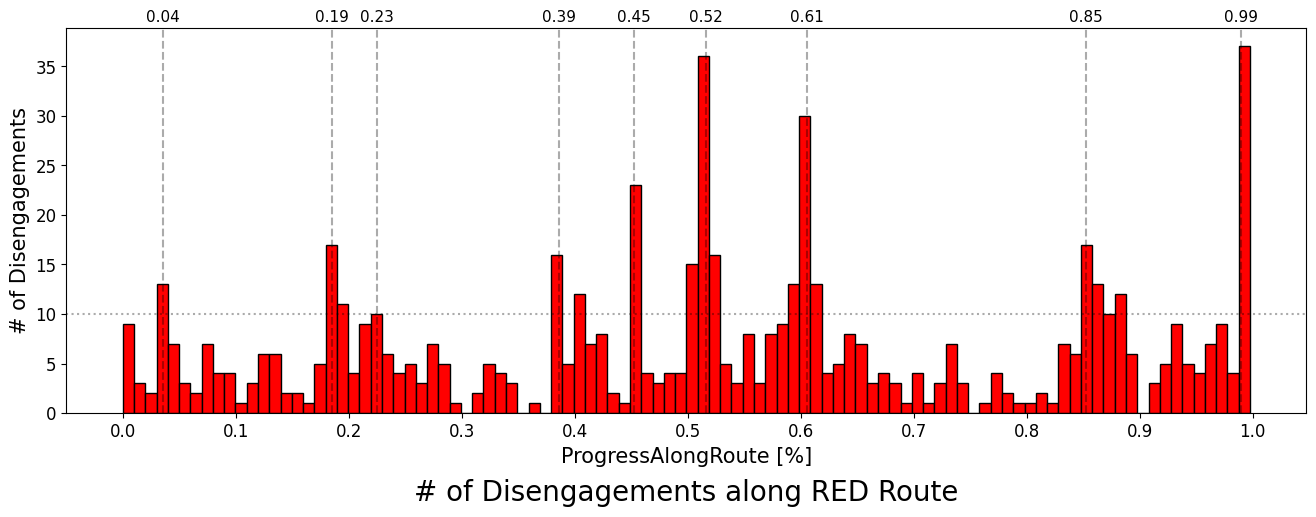

In [23]:
plt.figure( figsize = ( 16, 5 ) )

plt.hist( red_route_disengagement_progress_value_array, bins = 100, color = 'red', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along RED Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0.035, 0.185, 0.225, 0.386, 0.453, 0.516, 0.606, 0.853, 0.99 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for point in highlight_points_wanted:

    temp_array = np.abs( red_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = red_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

    plt.text( x = new_point - 0.03 / 2, y = 39.5, s = f'{ new_point :.2f}', fontsize = 11 )

#

plt.axhline( y = 10, color = 'black', ls = 'dotted', alpha = 0.33 )

plt.show()

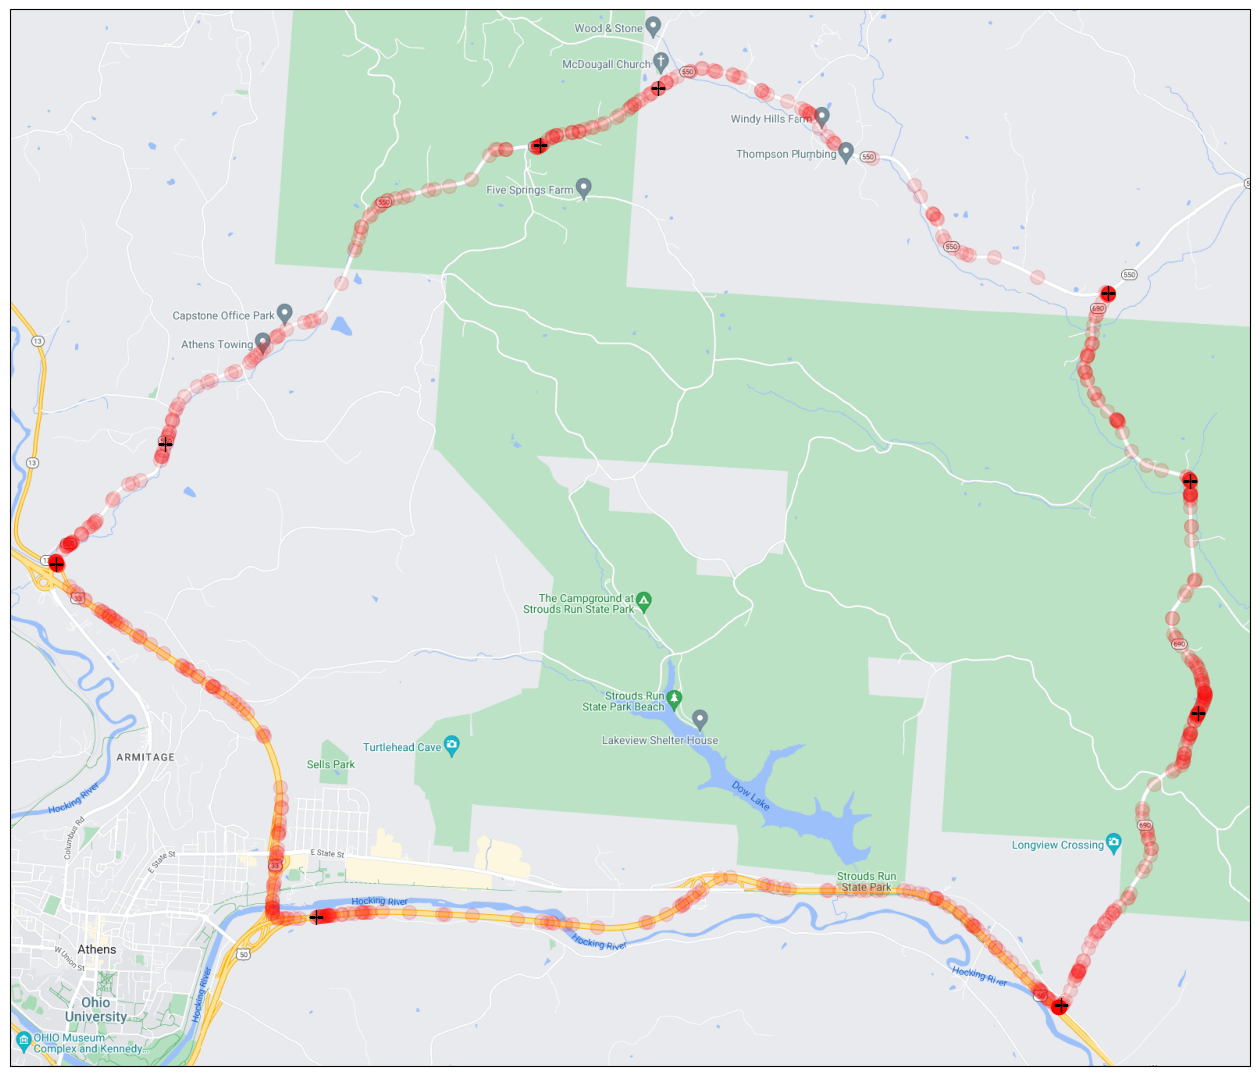

In [26]:
minLat = np.min( np.array( red_route_disengagement_subset_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_route_disengagement_subset_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_route_disengagement_subset_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_route_disengagement_subset_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

latitude_list = red_route_disengagement_subset_df[ 'latitude' ]

longitude_list = red_route_disengagement_subset_df[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'red', alpha = 1 / 8, ms = 10 )

#

peaks_df = red_route_disengagement_subset_df[ red_route_disengagement_subset_df[ 'ProgressAlongRoute' ].isin( highlight_points_actual ) ]

peaks_df = peaks_df.drop_duplicates( subset = 'ProgressAlongRoute' )

peaks_df = peaks_df.sort_values( 'ProgressAlongRoute' )

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1, ms = 10 )

plt.show()

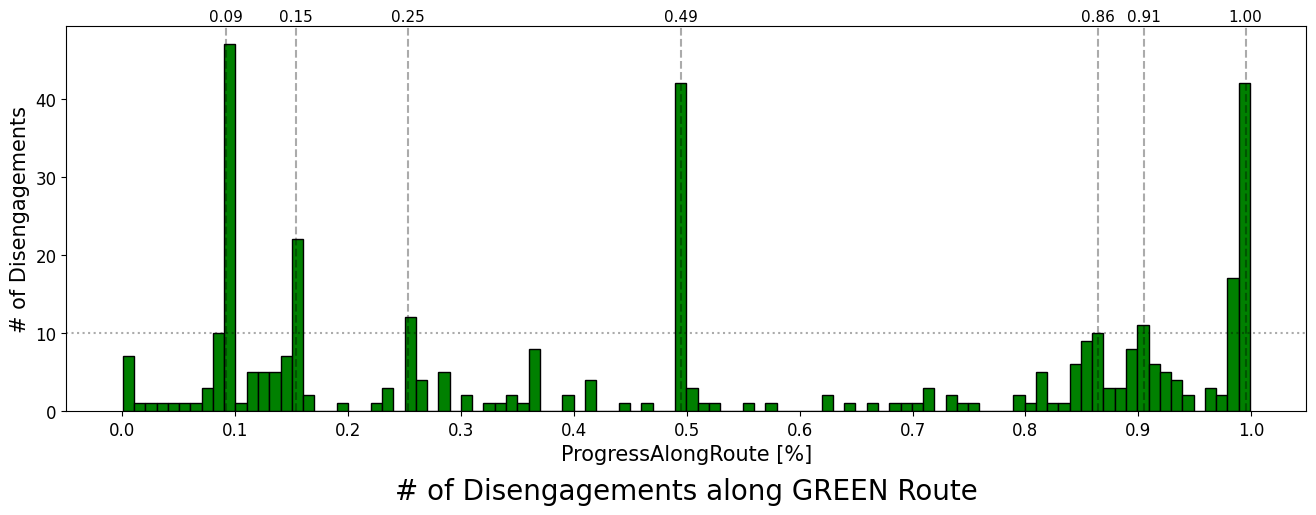

In [27]:
plt.figure( figsize = ( 16, 5 ) )

plt.hist( green_route_disengagement_progress_value_array, bins = 100, color = 'green', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along GREEN Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0.093, 0.154, 0.25, 0.495, 0.865, 0.905, 0.995 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for point in highlight_points_wanted:

    temp_array = np.abs( green_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = green_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

    plt.text( x = new_point - 0.03 / 2, y = 50, s = f'{ new_point :.2f}', fontsize = 11 )

#

plt.axhline( y = 10, color = 'black', ls = 'dotted', alpha = 0.33 )

plt.show()

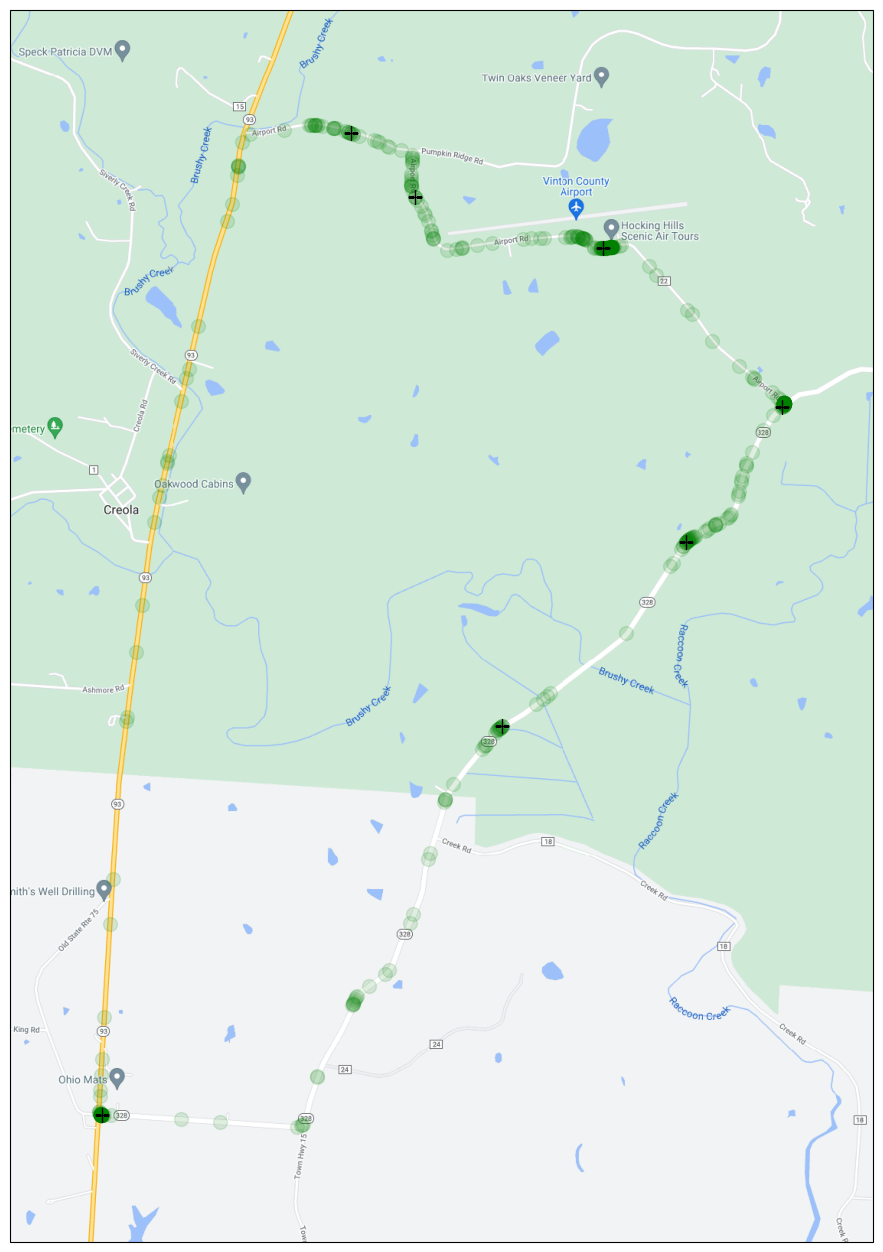

In [28]:
minLat = np.min( np.array( green_route_disengagement_subset_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_route_disengagement_subset_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_route_disengagement_subset_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_route_disengagement_subset_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 15)

latitude_list = green_route_disengagement_subset_df[ 'latitude' ]

longitude_list = green_route_disengagement_subset_df[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'green', alpha = 1 / 8, ms = 10 )

#

peaks_df = green_route_disengagement_subset_df[ green_route_disengagement_subset_df[ 'ProgressAlongRoute' ].isin( highlight_points_actual ) ]

peaks_df = peaks_df.drop_duplicates( subset = 'ProgressAlongRoute' )

peaks_df = peaks_df.sort_values( 'ProgressAlongRoute' )

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1, ms = 10 )

plt.show()

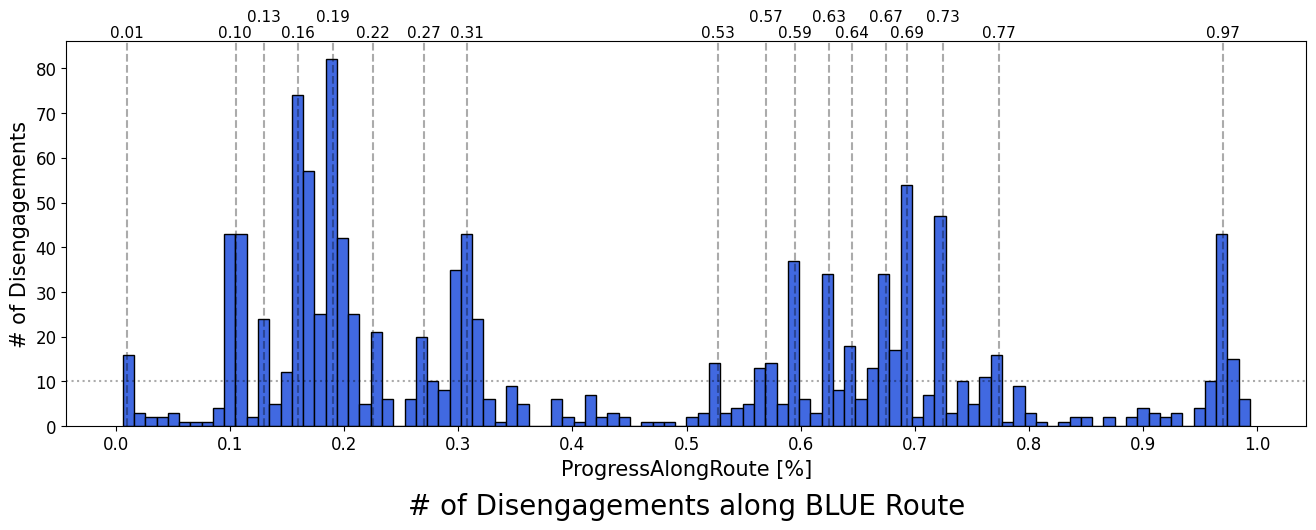

In [29]:
plt.figure( figsize = ( 16, 5 ) )

plt.hist( blue_route_disengagement_progress_value_array, bins = 100, color = 'royalblue', edgecolor = 'black' )

plt.xticks( np.linspace( 0, 1, 11 ) )

plt.xticks( fontsize = 12 )

plt.yticks( fontsize = 12 )

plt.xlabel( 'ProgressAlongRoute [%]', fontsize = 15 )

plt.ylabel( '# of Disengagements', fontsize = 15 )

plt.title( '# of Disengagements along BLUE Route', fontsize = 20, y = -0.25 )

#

highlight_points_wanted = [ 0.01, 0.105, 0.13, 0.16, 0.19, 0.225, 0.27, 0.307, 0.5275, 0.57, 0.595, 0.625, 0.645, 0.675, 0.693, 0.725, 0.775, 0.97 ]

highlight_points_actual_indexes = []

highlight_points_actual = []

for index, point in enumerate( highlight_points_wanted ):

    temp_array = np.abs( blue_route_disengagement_progress_value_array - point )

    index = np.where( temp_array == np.min( temp_array ) )[ 0 ][ 0 ]

    new_point = blue_route_disengagement_progress_value_array[ index ]

    highlight_points_actual_indexes.append( index )

    highlight_points_actual.append( new_point )

    plt.axvline( x = new_point, color = 'black', ls = '--', alpha = 0.33 )

#

plt.axhline( y = 10, color = 'black', ls = 'dotted', alpha = 0.33 )

plt.text( x = highlight_points_actual[ 0 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 0 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 1 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 1 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 2 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 2 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 3 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 3 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 4 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 4 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 5 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 5 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 6 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 6 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 7 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 7 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 8 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 8 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 9 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 9 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 10 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 10 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 11 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 11 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 12 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 12 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 13 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 13 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 14 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 14 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 15 ] - 0.03 / 2, y = 87 + 3.5, s = f'{ highlight_points_actual[ 15 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 16 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 16 ] :.2f}', fontsize = 11 )

plt.text( x = highlight_points_actual[ 17 ] - 0.03 / 2, y = 87, s = f'{ highlight_points_actual[ 17 ] :.2f}', fontsize = 11 )

plt.show()

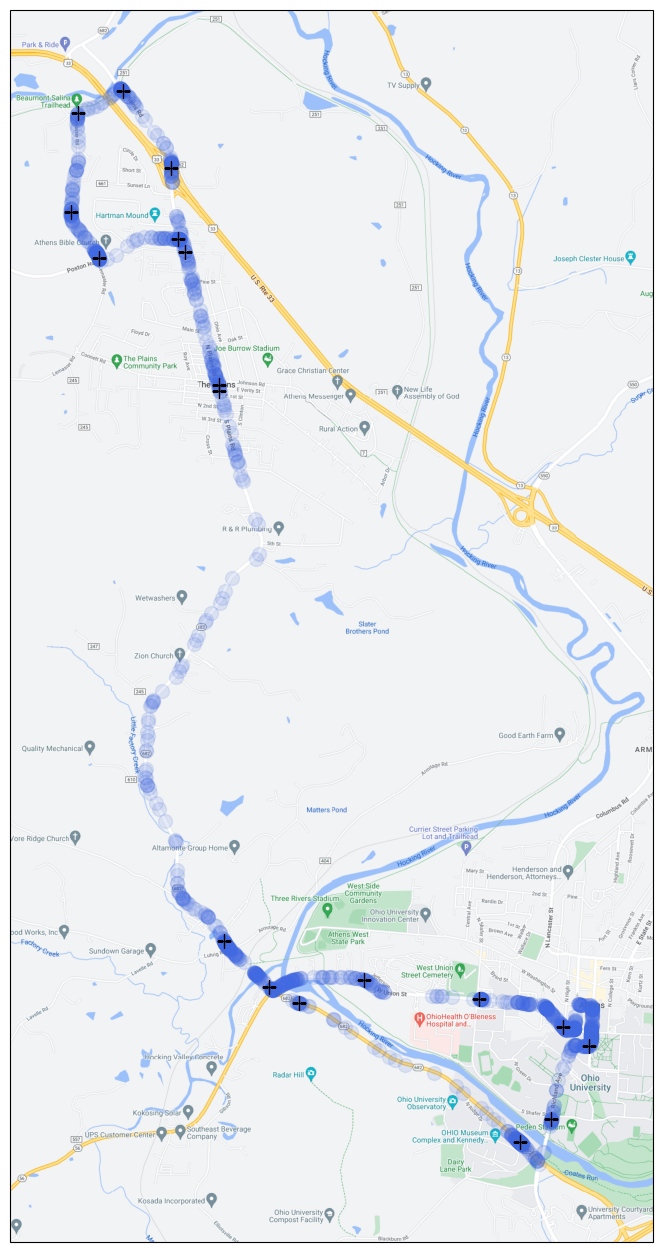

In [30]:
minLat = np.min( np.array( blue_route_disengagement_subset_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_route_disengagement_subset_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_route_disengagement_subset_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_route_disengagement_subset_df[ 'longitude' ] ) )

#

street_map = GoogleTiles( style = 'street' )

plt.figure( figsize = ( 16, 16 ) )

ax = plt.axes( projection = street_map.crs )

expansion_coeff = 0.005

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 15)

latitude_list = blue_route_disengagement_subset_df[ 'latitude' ]

longitude_list = blue_route_disengagement_subset_df[ 'longitude' ]

plt.plot( longitude_list, latitude_list, transform = ccrs.PlateCarree(), marker = 'o', ls = '', color = 'royalblue', alpha = 1 / 8, ms = 10 )

#

peaks_df = blue_route_disengagement_subset_df[ blue_route_disengagement_subset_df[ 'ProgressAlongRoute' ].isin( highlight_points_actual ) ]

peaks_df = peaks_df.drop_duplicates( subset = 'ProgressAlongRoute' )

peaks_df = peaks_df.sort_values( 'ProgressAlongRoute' )

peak_latitude_list = np.array( peaks_df[ 'latitude' ] )

peak_longitude_list = np.array( peaks_df[ 'longitude' ] )

peak_progress_list = np.array( peaks_df[ 'ProgressAlongRoute' ] )

plt.plot( peak_longitude_list, peak_latitude_list, transform = ccrs.PlateCarree(), marker = '+', ls = '', color = 'black', alpha = 1, ms = 10 )

plt.show()